In [14]:
import numpy as np

from triqs.gf import *

from itertools import product

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 100

In [64]:
class GWA:
    def __init__(self, t = 1.0, U = 1.5, eps = 0.0, beta = 200.0, nw = 50 * 1024):
        self.t = t
        self.U = U
        self.eps = eps
        self.beta = beta
        
        gf_struct = [('up', 2), ('dn', 2)]

        
        self.wmesh = MeshImFreq(beta, 'Fermion', int(nw))
        
        g_up = Gf(mesh = self.wmesh, target_shape=[2, 2])
        g_dn = Gf(mesh = self.wmesh, target_shape=[2, 2])
        self.fermionicGF = BlockGf(mesh = self.wmesh, gf_struct = gf_struct)
        
        self.bmesh = MeshImFreq(beta, 'Boson', int(nw))
        
        g_up = Gf(mesh = self.bmesh, target_shape=[2, 2])
        g_dn = Gf(mesh = self.bmesh, target_shape=[2, 2])
        self.bosonicGF = BlockGf(mesh = self.bmesh, gf_struct = gf_struct)
        
        self.omegaf = np.imag(np.array(list(self.fermionicGF['up'].mesh.values())))
        self.omegab = np.imag(np.array(list(self.bosonicGF['up'].mesh.values())))
        
        
        self.idmf = self.fermionicGF.copy()
        self.idmb = self.bosonicGF.copy()
        
        for name, g in self.idmf:
            self.idmf[name].data[:] = np.eye(2)
            self.idmb[name].data[:] = np.eye(2)
            
            
        self.G0 = self.ExactG(interactions = False)
        self.v = self.coulombPotential()
        self.vH = self.hatreePotential(self.v, self.G0)
        
        self.P = self.polarization(self.G0)
        self.W = self.screenedPotential(self.P, self.v)
        self.Σ = self.selfEnergy(self.G0, self.W)
        self.GW = self.greenFunction(self.G0, self.Σ, self.vH)
    
    def ExactGW(self):
        h = np.sqrt(4 * self.t ** 2 + 4 * self.U * self.t)

        A = np.sqrt((2 * self.t + h + self.U / 2) ** 2 + 4 * self.U ** 2 * self.t / h)
        B = np.sqrt((2 * self.t + h - self.U / 2) ** 2 + 4 * self.U ** 2 * self.t / h)

        w1_p = (2 * self.eps - h + self.U / 2 + A) / 2
        w1_m = (2 * self.eps - h + self.U / 2 - A) / 2

        w2_p = (2 * self.eps + h + self.U / 2 + B) / 2
        w2_m = (2 * self.eps + h + self.U / 2 - B) / 2

        R1 = ( h + 2 * self.t + self.U / 2) / (4 * A)
        R2 = (-h - 2 * self.t + self.U / 2) / (4 * B)
        
        def greenDiag():
            return (0.25 + R1) * inverse(iOmega_n - w1_p) + (0.25 - R1)*inverse(iOmega_n - w1_m) \
                 + (0.25 + R2)* inverse(iOmega_n - w2_p) + (0.25 - R2) * inverse(iOmega_n - w2_m)

        def greenOffDiag():
            return - (0.25 + R1) * inverse(iOmega_n - w1_p) - (0.25 - R1) * inverse(iOmega_n - w1_m) \
                   + (0.25 + R2) * inverse(iOmega_n - w2_p) + (0.25 - R2) * inverse(iOmega_n - w2_m)

        G = self.fermionicGF.copy()
        
        indices = (0, 1)
        for i, j in product(indices, indices):
            G['up'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)
            G['dn'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)

        return G

    def ExactG(self, interactions = True):
        U = self.U * int(interactions)
    
        c = np.sqrt(16 * self.t ** 2 + U * 2)
        a = np.sqrt(2 * (16 * self.t ** 2 / ((c - U) ** 2) + 1))
        b = np.sqrt(2 * (16 * self.t ** 2 / ((c + U) ** 2) + 1))
        
        w1 = self.eps - self.t + (c + U) / 2
        w2 = self.eps + self.t + (c + U) / 2
        w3 = self.eps + self.t - (c - U) / 2
        w4 = self.eps - self.t - (c - U) / 2
        
        R1 = (1 + 4 * self.t / (c - U)) ** 2
        R2 = (1 - 4 * self.t / (c - U)) ** 2
        

        def greenDiag():
            return (R1 * inverse(iOmega_n - w1) + R2 * inverse(iOmega_n - w2)) / (2 * a ** 2) \
                 + (R1 * inverse(iOmega_n - w3) + R2 * inverse(iOmega_n - w4)) / (2 * a ** 2)

        def greenOffDiag():
            return -1 * (R1 * inverse(iOmega_n - w1) - R2 * inverse(iOmega_n - w2)) / (2 * a ** 2) \
                 + (R1 * inverse(iOmega_n - w3) -
                    R2 * inverse(iOmega_n - w4)) / (2 * a ** 2)
        
        G = self.fermionicGF.copy()
        
        indices = (0, 1)
        for i, j in product(indices, indices):
            G['up'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)
            G['dn'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)

        return G
    
    def ExactP(self):
        def greenDiag():
            return (inverse(iOmega_n - 2 * self.t) - inverse(iOmega_n + 2 * self.t)) / 4

        def greenOffDiag():
            return -1 * (inverse(iOmega_n - 2 * self.t) - inverse(iOmega_n + 2 * self.t)) / 4
        
        G = self.bosonicGF.copy()
        
        indices = (0, 1)
        for i, j in product(indices, indices):
            G['up'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)
            G['dn'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)

        return G

    def ExactW(self):
        Wdiag = Gf(mesh = self.bmesh, target_shape = [])
        Woffdiag = Gf(mesh = self.bmesh, target_shape = [])
        
        h2 = 4 * self.t ** 2 + 4 * self.U * self.t
        
        for w in self.bmesh:
            Wdiag[w] = self.U + 2 * self.U ** 2 * self.t / (complex(w) ** 2 - h2)
            Woffdiag[w] = 0   - 2 * self.U ** 2 * self.t / (complex(w) ** 2 - h2)

        G = self.bosonicGF.copy()
        
        indices = (0, 1)
        for i, j in product(indices, indices):
            G['up'][i, j] << Wdiag * int(i == j) + Woffdiag * int(i != j)
            G['dn'][i, j] << Wdiag * int(i == j) + Woffdiag * int(i != j)

        return G
    
    def ExactΣ(self):
        h = np.sqrt(4 * self.t ** 2 + 4 * self.t * self.U)
        w1 = self.eps + self.t + h
        w2 = self.eps - self.t - h
        
        def greenDiag():
            return self.U / 2 + self.U ** 2 * self.t * (inverse(iOmega_n - w1) + inverse(iOmega_n - w2)) / (2 * h)

        def greenOffDiag():
            return      0     + self.U ** 2 * self.t * (inverse(iOmega_n - w1) - inverse(iOmega_n - w2)) / (2 * h)
        
        G = self.fermionicGF.copy()
        
        indices = (0, 1)
        for i, j in product(indices, indices):
            G['up'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)
            G['dn'][i, j] << greenDiag() * int(i == j) + greenOffDiag() * int(i != j)

        return G

    def coulombPotential(self):
        v = self.bosonicGF.copy()
        for name, g in v:
            v[name].data[:] = np.eye(2) * self.U
        return v
    
    def hatreePotential(self, v, G):
        vH = self.fermionicGF.copy()
        
        for name, g in vH:
            vH[name].data[:-1] = self.v[name].data[:] * G[name].density()
            vH[name].data[-1] = self.v[name].data[-1] * G[name].density()
    
        return vH
    
    def onMesh(*args):
        arglist = []
        for arg in args:
            arglist.append(arg)
            
        arglist.pop(0)
        if len(arglist) <= 1:
            return arglist[0]
        
        
        for i, arg in enumerate(arglist[1:]):
            new_arg = arglist[0].copy()
            for name, g in arg:
                new_arg[name].data[:] = arg[name].data[:]
            arglist[i+1] = new_arg
        return arglist

    def polarization(self, G):
        
        G = make_gf_from_fourier(G)
        P = make_gf_from_fourier(self.bosonicGF).copy()
        
        for name, g in P:    
            P[name].data[:] = -G[name].transpose().data[::-1, :, :] * G[name].data[:, :, :]

        return P
    
    def screenedPotential(self, P, v):
        P = make_gf_from_fourier(P)
        
        P, v, idmb = self.onMesh(P, v, self.idmb)
        
        W = (idmb - v * 2 * P).inverse() * v
        
        return W
    
    def selfEnergy(self, G, W):
        G = make_gf_from_fourier(G)
        shift = W['up'].data[-1, 0 ,0]
        # print(shift, self.U)
        W = make_gf_from_fourier(W - np.real(shift))

        Σ = make_gf_from_fourier(self.fermionicGF).copy()

        for name, g in Σ:
            Σ[name].data[:] =  -G[name].data[:] * W[name].data[:]

        return Σ
    
    def greenFunction(self, G0, Σ, vH):
        Σ = make_gf_from_fourier(Σ) + vH

        G0, Σ = self.onMesh(G0, Σ)

        return (G0.inverse() - Σ).inverse()
    
    def sanityCheck(self):
        spin = 'up'
        P = make_gf_from_fourier(self.P)
        W = self.W
        Σ = make_gf_from_fourier(self.Σ) + self.vH
        G = self.GW
        
        
        print("Polarization : Pass") if np.allclose(P[spin].data, self.ExactP()[spin].data) else print("Polarization : Fail")
        print("Screened Potential : Pass") if np.allclose(W[spin].data, self.ExactW()[spin].data) else print("Screened Potential : Fail")
        print("Self-Energy : Pass") if np.allclose(Σ[spin].data, self.ExactΣ()[spin].data) else print("Self-Energy: Fail")
        print("GW Green function : Pass") if np.allclose(G[spin].data, self.ExactGW()[spin].data) else print("GW Green function : Fail")

In [65]:
gw = GWA()
wf = gw.omegaf
wb = gw.omegab


G0 = gw.G0
Ge = gw.ExactG()
GWe = gw.ExactGW()
Pe = gw.ExactP()
We = gw.ExactW()
Σe = gw.ExactΣ()


Ptau = gw.P
Pomeg = make_gf_from_fourier(Ptau)

Womeg = gw.W

Σtau = gw.Σ
Σomeg = make_gf_from_fourier(Σtau) + gw.vH

Gomeg = gw.GW

gw.sanityCheck()

        

Polarization : Pass
Screened Potential : Pass
Self-Energy : Pass
GW Green function : Pass


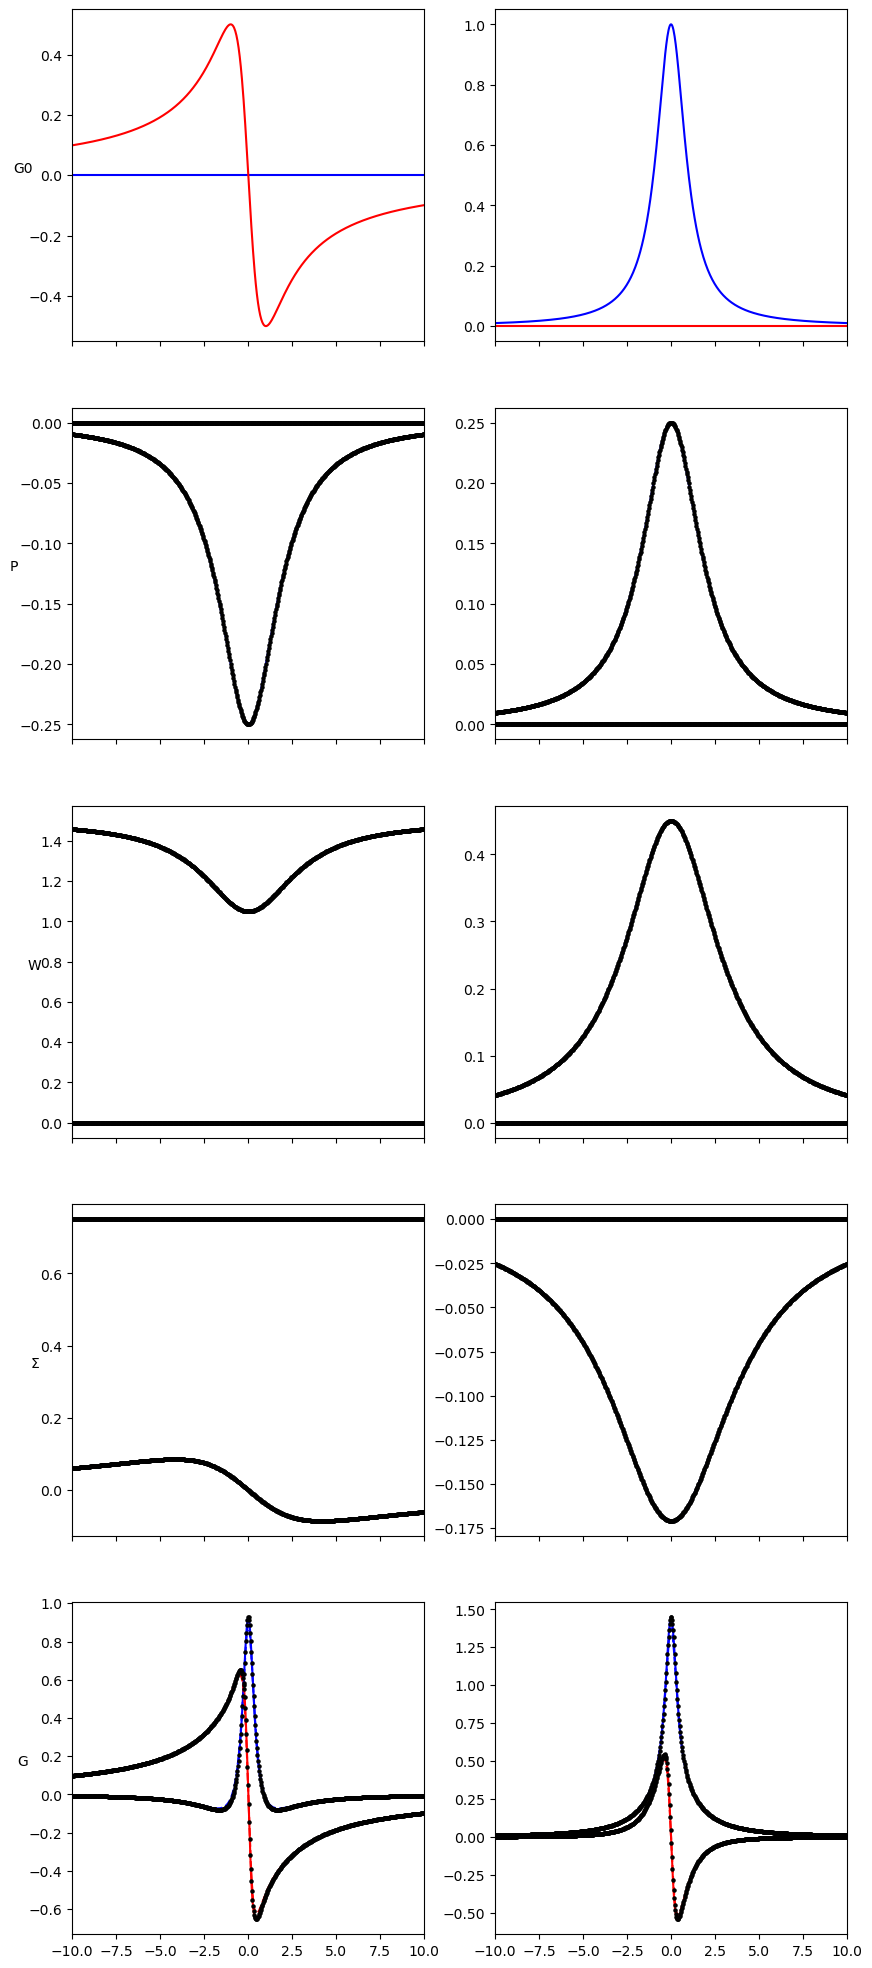

In [66]:
spin = 'up'
xlim = [-10, 10]
s = 5

fig, axs = plt.subplots(5, 2, sharex = 'col', figsize = (10, 25))

axs[0, 0].set_xlim(xlim)
axs[0, 1].set_xlim(xlim)

# G0 plot
axs[0, 0].set_ylabel('G0', rotation = 0)
axs[0, 0].plot(wf, np.real(G0[spin].data[:, 0,0]), color = 'blue', zorder = 0)
axs[0, 0].plot(wf, np.imag(G0[spin].data[:, 0,0]), color = 'red', zorder = 0)


axs[0, 1].plot(wf, np.real(G0[spin].data[:, 0,1]), color = 'blue', zorder = 0)
axs[0, 1].plot(wf, np.imag(G0[spin].data[:, 0,1]), color = 'red', zorder = 0)

# P plot
axs[1, 0].set_ylabel('P', rotation = 0)
axs[1, 0].plot(wb, np.real(Pe[spin].data[:, 0,0]), color = 'blue', zorder = 0)
axs[1, 0].plot(wb, np.imag(Pe[spin].data[:, 0,0]), color = 'red', zorder = 0)


axs[1, 1].plot(wb, np.real(Pe[spin].data[:, 0,1]), color = 'blue', zorder = 0)
axs[1, 1].plot(wb, np.imag(Pe[spin].data[:, 0,1]), color = 'red', zorder = 0)


axs[1, 0].scatter(wb, np.real(Pomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)
axs[1, 0].scatter(wb, np.imag(Pomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)


axs[1, 1].scatter(wb, np.real(Pomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)
axs[1, 1].scatter(wb, np.imag(Pomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)


# W plot
axs[2, 0].set_ylabel('W', rotation = 0)
axs[2, 0].plot(wb, np.real(We[spin].data[:, 0,0]), color = 'blue', zorder = 0)
axs[2, 0].plot(wb, np.imag(We[spin].data[:, 0,0]), color = 'red', zorder = 0)


axs[2, 1].plot(wb, np.real(We[spin].data[:, 0,1]), color = 'blue', zorder = 0)
axs[2, 1].plot(wb, np.imag(We[spin].data[:, 0,1]), color = 'red', zorder = 0)



axs[2, 0].scatter(wb, np.real(Womeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)
axs[2, 0].scatter(wb, np.imag(Womeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)


axs[2, 1].scatter(wb, np.real(Womeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)
axs[2, 1].scatter(wb, np.imag(Womeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)

# Σ plot
axs[3, 0].set_ylabel('Σ', rotation = 0)
axs[3, 0].plot(wf, np.real(Σe[spin].data[:, 0,0]), color = 'blue', zorder = 0)
axs[3, 0].plot(wf, np.imag(Σe[spin].data[:, 0,0]), color = 'red', zorder = 0)


axs[3, 1].plot(wf, np.real(Σe[spin].data[:, 0,1]), color = 'blue', zorder = 0)
axs[3, 1].plot(wf, np.imag(Σe[spin].data[:, 0,1]), color = 'red', zorder = 0)



axs[3, 0].scatter(wf, np.real(Σomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)
axs[3, 0].scatter(wf, np.imag(Σomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)


axs[3, 1].scatter(wf, np.real(Σomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)
axs[3, 1].scatter(wf, np.imag(Σomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)

# G plot
axs[4, 0].set_ylabel('G', rotation = 0)
axs[4, 0].plot(wf, np.real(GWe[spin].data[:, 0,0]), color = 'blue', zorder = 0)
axs[4, 0].plot(wf, np.imag(GWe[spin].data[:, 0,0]), color = 'red', zorder = 0)


axs[4, 1].plot(wf, np.real(GWe[spin].data[:, 0,1]), color = 'blue', zorder = 0)
axs[4, 1].plot(wf, np.imag(GWe[spin].data[:, 0,1]), color = 'red', zorder = 0)


axs[4, 0].scatter(wf, np.real(Gomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)
axs[4, 0].scatter(wf, np.imag(Gomeg[spin].data[:, 0,0]), color = 'black', s = s, zorder = 1)


axs[4, 1].scatter(wf, np.real(Gomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)
axs[4, 1].scatter(wf, np.imag(Gomeg[spin].data[:, 0,1]), color = 'black', s = s, zorder = 1)


axs[4, 0].plot(wf, np.real(Ge[spin].data[:, 0,0]), color = 'blue', linestyle = '--', zorder = 0)
axs[4, 0].plot(wf, np.imag(Ge[spin].data[:, 0,0]), color = 'red', linestyle = '--', zorder = 0)


axs[4, 1].plot(wf, np.real(Ge[spin].data[:, 0,1]), color = 'blue', linestyle = '--', zorder = 0)
axs[4, 1].plot(wf, np.imag(Ge[spin].data[:, 0,1]), color = 'red', linestyle = '--', zorder = 0)

plt.show()

In [89]:
beta = 0.1
nw = 1024

wmesh = MeshImFreq(beta, 'Boson', int(nw))
g_up = Gf(mesh = wmesh, target_shape=[2, 2])
wb = np.array(list(g_up.mesh.values()))

wmesh = MeshImFreq(beta, 'Fermion', int(nw))
g_up = Gf(mesh = wmesh, target_shape=[2, 2])
wf = np.array(list(g_up.mesh.values()))


def ifmesh(beta, statistic, nw):
    if statistic == 'Fermion':
        wmax = (2 * (nw - 1) + 1) * np.pi / beta
        return np.linspace(-wmax, wmax, 2 * nw) * 1j
    elif statistic == 'Boson':
        wmax = (2 * (nw - 1)) * np.pi / beta
        mesh_p = np.linspace(0, wmax, nw) * 1j
        mesh_m = (-np.linspace(0, wmax, nw) * 1j)[::-1]
        return np.concatenate((mesh_m[:-1], mesh_p))


print(np.allclose(wf, ifmesh(beta, 'Fermion', nw)))
print(np.allclose(wb, ifmesh(beta, 'Boson', nw)))

True
True
